#### Import Libraries

In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
import matplotlib.pyplot as plt
import random
import numpy as np

#### Load data and set seed

In [8]:
# Set seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
set_seed(42)

# Load data
df = pd.read_csv('../data/raw_data/bank_marketing_dataset.csv')
df.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,subscribed
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


#### Re-use code to calculate ROI from Q8

In [9]:
#### Use ROI code from Q8 ######
# Pre-processing
## Convert binary categorical variables to numeric
binary_features = ['housing', 'loan', 'subscribed']
for col in binary_features:
    df[col] = df[col].map({'no': 0, 'yes': 1})

## Convert contact type to binary
df['contact'] = df['contact'].map({'telephone': 0, 'cellular': 1})

## Convert to ordinal values
poutcome_mapping = {'failure': 0, 'nonexistent': 1, 'success': 2}
df['poutcome'] = df['poutcome'].map(poutcome_mapping)

default_mapping = {'no': 0, 'unknown': 1, 'yes': 2}
df['default'] = df['default'].map(default_mapping)

## Bin pdays and previous
df['pdays_bins'] = df['pdays'].apply(lambda x: 'Never Contacted' if x == 999 else ('1-5' if x <= 5 else '6+'))
df['previous_bins'] = pd.cut(df['previous'], bins=[-1, 0, 1, float('inf')], labels=['Never', '1', '2+'])

## Drop unnecessary columns
df = df.drop(columns=['pdays', 'previous', 'emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed'])

# Calculate ROI
## (Take conversion rate/previous campaign success rate into account)
## Calculate conversion rate among those who did not subscribe in previous campaign
success_df = df[df['poutcome'] != 2]
conversion_rate = sum(success_df['subscribed'] == 1) / success_df.shape[0]

## Calculate previous campaign success rate
prev_campaign = df['poutcome'].value_counts()
prev_success = prev_campaign[2] / (prev_campaign[0] + prev_campaign[2])

## Function to calculate CLV
def calculate_clv(row):
    clv = 100  # base CLV
    # Factor in previous campaign outcome
    if row['poutcome'] == 2:
        prob_conversion = 1 + prev_success
    elif row['poutcome'] == 0:
        prob_conversion = conversion_rate
    else:
        prob_conversion = 1
    clv *= prob_conversion # Adjust CLV based on conversion probability
    # Factor in other customer attributes
    if row['subscribed'] == 1:
        clv += 200
    if row['housing'] == 1:
        clv += 100  # Housing loan customers indicate a long-term banking relationship
    if row['loan'] == 1:
        clv += 100  # Personal loan customers may need more banking products
    if row['marital'] == 'single':
        clv += 50 # More financial independence
    if row['education'] in ['university.degree', 'professional.course']:
        clv += 50  # More financially aware customers may invest more
    if row['job'] in ['management', 'entrepreneur', 'self-employed']:
        clv += 50  # Higher earning potential, more banking needs
    if row['default'] == 2:
        clv -= 200 # Penalty for defaulting customers
    return max(clv, 0)  # CLV should be non-negative

df['clv'] = df.apply(calculate_clv, axis=1)

## Function to calculate customer acquisition cost
def calculate_acquisition_cost(row):
    if row['campaign'] == 0 or row['duration'] == 0:
        return 0.01  # minimum acquisition cost to avoid division by 0
    cps = 0.05 if row['contact'] == 1 else 0.03 # cost per second
    return row['campaign'] * row['duration'] * cps

df['acquisition_cost'] = df.apply(calculate_acquisition_cost, axis=1)

# Calculate ROI
df['roi'] = ((df['clv'] - df['acquisition_cost']) / df['acquisition_cost']) * 100

#### Encode categorical variables and clean up the rest of the columns

In [10]:
# Keep a copy of unencoded data
df_unscaledcopy = df.copy()

# Encode categorical variables
categorical_features = ['job', 'marital', 'education', 'month', 'day_of_week', 'pdays_bins', 'previous_bins']
encoder = OneHotEncoder(drop='first', sparse_output=False)
categorical_encoded = encoder.fit_transform(df[categorical_features])
categorical_df = pd.DataFrame(categorical_encoded, columns=encoder.get_feature_names_out())

## Drop original columns and merge encoded ones
df = df.drop(columns=categorical_features)
df = pd.concat([df, categorical_df], axis=1)

## Fill missing values
imputer = SimpleImputer(strategy='most_frequent')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

#### Re-use code to generate customer clusters from Q1

In [11]:
#### Use Clustering code from Q1 ######
wcss = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)

# Apply KMeans clustering with k=3
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(df)
df_unscaledcopy['cluster'] = df['cluster'] ##for visualisation of clusters

# Perform PCA to reduce the data to 2 components for visualisation
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df.drop(columns=['cluster']))

# Analyse clusters
cluster_summary = df_unscaledcopy.groupby('cluster').agg({
    'roi': ['mean', 'median'],
    'clv': ['mean', 'median'],
    'acquisition_cost': ['mean', 'median'],
    'subscribed': 'mean',
}).round(2)

print(cluster_summary)

                roi                 clv        acquisition_cost         \
               mean      median    mean median             mean median   
cluster                                                                  
0           2609.00     1355.60  223.72  200.0            25.86  13.60   
1        2333233.33  1999900.00  233.33  200.0             0.01   0.01   
2         172485.18   136011.11  250.02  250.0             0.18   0.18   

        subscribed  
              mean  
cluster             
0             0.11  
1             0.00  
2             0.00  


#### Analyze ROI quartiles by job, education and marital status

In [12]:
categorical_cols = ['job', 'education', 'marital']

for col in categorical_cols:
    print(f"\n{col.upper()} DISTRIBUTION BY CLUSTER")
    print(df_unscaledcopy.groupby('cluster')[col].value_counts(normalize=True).unstack().round(2))

roi_quartiles = df_unscaledcopy['roi'].quantile([0.25, 0.5, 0.75])
print(roi_quartiles)


JOB DISTRIBUTION BY CLUSTER
job      admin.  blue-collar  entrepreneur  housemaid  management  retired  \
cluster                                                                      
0          0.25         0.22          0.04       0.03        0.07     0.04   
1          0.33         0.33           NaN        NaN        0.33      NaN   
2          0.21         0.18          0.06       0.02        0.06     0.03   

job      self-employed  services  student  technician  unemployed  unknown  
cluster                                                                     
0                 0.03      0.10     0.02        0.16        0.02     0.01  
1                  NaN       NaN      NaN         NaN         NaN      NaN  
2                 0.03      0.09     0.08        0.21        0.03      NaN  

EDUCATION DISTRIBUTION BY CLUSTER
education  basic.4y  basic.6y  basic.9y  high.school  illiterate  \
cluster                                                            
0              0.10     

#### Define ROI segments by separating into 25th, 50th and 75th quartiles

In [13]:
# Define the ROI segments
roi_quartiles = df['roi'].quantile([0.25, 0.5, 0.75])

# Create a new column for ROI segments based on quartiles
def classify_roi(row):
    if row['roi'] < roi_quartiles[0.25]:
        return 'Low ROI'
    elif row['roi'] < roi_quartiles[0.75]:
        return 'Medium ROI'
    else:
        return 'High ROI'

df['roi_segment'] = df.apply(classify_roi, axis=1)

#### Split into train-test set

In [16]:
# Select features and target variable
X = df.drop(columns=['roi', 'roi_segment', 'cluster'])  # Drop ROI, roi_segment, and cluster columns
y = df['roi_segment']  # Target variable is the ROI segment

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Determine the best max depth for the Decision Tree Classifier to grow until the accuracy is maximized

In [17]:
# Determine the best max_depth for the decision tree classifier
accuracy_scores = []
depths = list(range(3,21))
for depth in depths:
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(f"Depth {depth}: Mean Accuracy = {scores.mean()}")
    accuracy_scores.append(scores.mean())
best_depth = depths[accuracy_scores.index(max(accuracy_scores))]

Depth 3: Mean Accuracy = 0.8005950771987542
Depth 4: Mean Accuracy = 0.8834354003364104
Depth 5: Mean Accuracy = 0.9368254634647171
Depth 6: Mean Accuracy = 0.9599392458244841
Depth 7: Mean Accuracy = 0.9839755674652148
Depth 8: Mean Accuracy = 0.9918903898329068
Depth 9: Mean Accuracy = 0.9958237870717761
Depth 10: Mean Accuracy = 0.9965521958236337
Depth 11: Mean Accuracy = 0.9971835231002361
Depth 12: Mean Accuracy = 0.9971106810460902
Depth 13: Mean Accuracy = 0.9973049265238126
Depth 14: Mean Accuracy = 0.9973049265238126
Depth 15: Mean Accuracy = 0.9973049265238126
Depth 16: Mean Accuracy = 0.9973049265238126
Depth 17: Mean Accuracy = 0.9973049265238126
Depth 18: Mean Accuracy = 0.9973049265238126
Depth 19: Mean Accuracy = 0.9973049265238126
Depth 20: Mean Accuracy = 0.9973049265238126


#### Visualize the depth vs accuracy
- Accuracy is maximized at Depth = 13

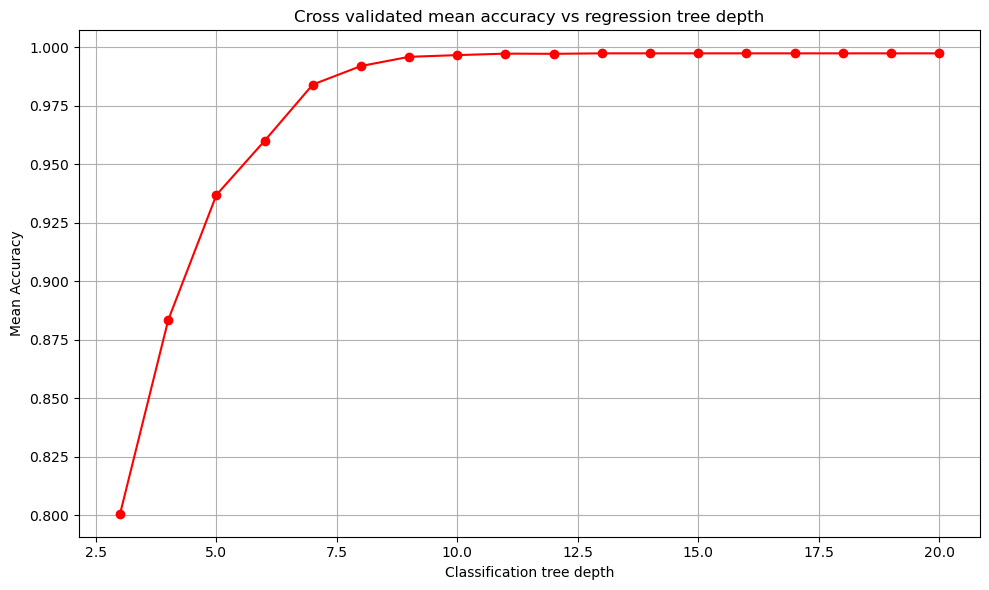

In [18]:
# Plot accuracy vs depth
plt.figure(figsize=(10, 6))
plt.plot(depths, accuracy_scores, marker='o', linestyle='-', color='red')
plt.title("Cross validated mean accuracy vs regression tree depth")
plt.xlabel("Classification tree depth")
plt.ylabel("Mean Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Train the decision tree classifier with max_depth = 13
- Model achieves high accuracy of **0.997**

In [22]:
# Train a decision tree classifier
dtc = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
dtc.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dtc.predict(X_test)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

    High ROI       1.00      1.00      1.00      3142
     Low ROI       1.00      1.00      1.00      3025
  Medium ROI       1.00      1.00      1.00      6190

    accuracy                           1.00     12357
   macro avg       1.00      1.00      1.00     12357
weighted avg       1.00      1.00      1.00     12357

Confusion Matrix:
 [[3135    0    7]
 [   0 3018    7]
 [   5   12 6173]]


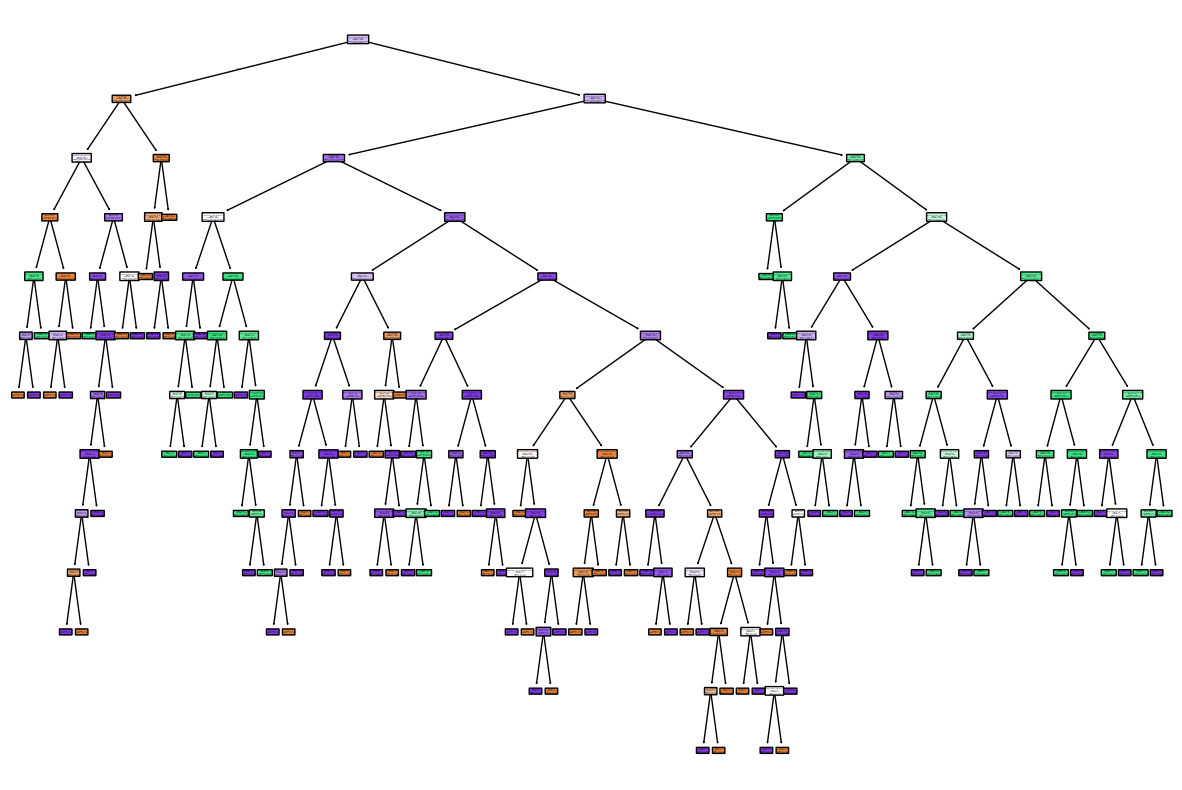

In [23]:
# Visualize the decision tree
plt.figure(figsize=(15, 10))
tree.plot_tree(dtc, filled=True, feature_names=X.columns, class_names=['Low ROI', 'Medium ROI', 'High ROI'], rounded=True)
plt.show()